# Intro

This notebook provides minimal functionality for applying DMD to noisy climate data. 

The following capabilities are implemented:

* use mask to remove land pixels from training
* window average (window before current time)
* densely sample weekly means around local mins of total ice
* model monthly across years


In [1]:
%load_ext autoreload
%autoreload 2
import dill

import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD, FbDMD, MrDMD
from pydmd.plotter import plot_eigs, plot_summary, plot_modes_2D
from pydmd.preprocessing import hankel_preprocessing

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.ndimage import gaussian_filter

from tqdm.autonotebook import tqdm, trange

from scipy.signal import fftconvolve

import sys

sys.path.insert(0, '../src/WeatherDMD/')

from WeatherDMD.plot_jupyter import contour_compare, contour_data
from WeatherDMD.data_wrangle import get_days_before, get_test_set, window_mean
from WeatherDMD.dmd_routines import reshape_data2dmd, train_dmd, reshape_Psi2data, eval_dmd

import xarray as xr

from WeatherDMD import data_pipeline

/var/folders/3p/bn7y7hcd6s7_28j4tq3cv2hr0000gs/T/ipykernel_57995/1018395117.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# DATA

In [2]:
dSet = data_pipeline.load_data("2020-01-01_2020-02-27_era5_slice_resampled.zarr")  

In [3]:
dSet

<xarray.Dataset> Size: 724MB
Dimensions:              (time: 232, level: 1, latitude: 361, longitude: 720)
Coordinates:
  * latitude             (latitude) float32 1kB 90.0 89.5 89.0 ... -89.5 -90.0
  * level                (level) int64 8B 1000
  * longitude            (longitude) float32 3kB 0.0 0.5 1.0 ... 359.0 359.5
  * time                 (time) datetime64[ns] 2kB 2020-01-01 ... 2020-02-27T...
Data variables:
    geopotential         (time, level, latitude, longitude) float32 241MB ...
    temperature          (time, level, latitude, longitude) float32 241MB ...
    u_component_of_wind  (time, level, latitude, longitude) float32 241MB ...

In [4]:
# calculate the unique delta time in hours
delta_time = np.unique(np.diff(dSet.time))
delta_time_hrs = delta_time/np.timedelta64(1, 'h')
delta_time_hrs = delta_time_hrs[0]
print(f"The unique delta time is {delta_time_hrs} hours")

The unique delta time is 6.0 hours


In [5]:
# currently the number of points in lat and lon need to be the same for this pipeline to work
lat_min = dSet["latitude"].values[0]
lat_max = dSet["latitude"].values[-1]
lon_min = dSet["longitude"].values[180]
lon_max = dSet["longitude"].values[540] 
data, attrs, coords, dims = data_pipeline.dataset_to_array(
    dSet, variable="temperature", downsample=2, subregion=(lat_min, lat_max, lon_min, lon_max) 
)

In [6]:
data.shape

(232, 180, 180)

In [7]:
coords

Coordinates:
  * latitude   (latitude) float32 720B 89.75 88.75 87.75 ... -88.25 -89.25
    level      int64 8B 1000
  * longitude  (longitude) float32 720B 90.25 91.25 92.25 ... 267.2 268.2 269.2
  * time       (time) datetime64[ns] 2kB 2020-01-01 ... 2020-02-27T18:00:00

In [8]:
DATA = np.array(data)[None, ...]

In [9]:
DATA.shape

(1, 232, 180, 180)

In [10]:
contour_data(data)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=231), IntSlider(value=90, description='f_…

In [11]:
x = np.linspace(0, 1, data.shape[2])
y = np.linspace(0, 1, data.shape[1])

In [12]:
# compute the integral of the field along the x and y axis (across space)
Integral_eval = np.trapz(np.trapz(data, x, axis = 2), y, axis = 1)

Text(0, 0.5, 'Integral of the field')

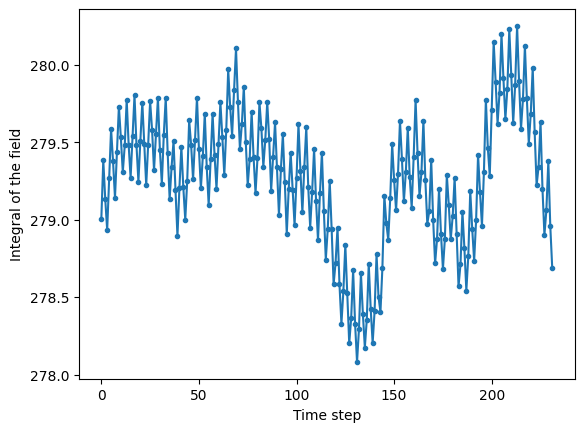

In [13]:
fig, ax = plt.subplots()
plt.plot(Integral_eval, '.-')
plt.xlabel('Time step')
plt.ylabel('Integral of the field')

## Train optimised DMD

DMD does not really require batching the data in the deep-AI sense. We simply need to select a training interval and fit DMD. After fitting, DMD model with fitted parameters can be used for prediction on any time interval. 

1. Identify a starting point in time by `year`, `day` 
2. Identify, how many days to train on: `T_train`
3. Select subset of `DATA`, based on the above. Perform window-averaging to de-noise it. 
4. Fit DMD. 
5. Compute DMD predictions from `year`, `day` forward. 

In [14]:
DATA[0].shape

(232, 180, 180)

In [15]:
len(DATA)

1

In [16]:
# get training data
year = 0
day = 150

window = 10
T_train = 100

X0_ = get_days_before(DATA, year, day, T_train+window-1)
X0_.shape

(109, 180, 180)

In [17]:
(X0_ == data[day-T_train-window+1:day, :, :]).all()

True

In [18]:
timestamps = coords["time"][day-T_train-window+1:day]
len(timestamps)

109

In [19]:
# compute windowed mean. Returns T_train snapshots before current time point (not inclusive)
X0, timestamps_windowed = window_mean(X0_, window = window, t = timestamps)
X0_.shape, X0.shape, timestamps_windowed.shape

((109, 180, 180), (100, 180, 180), (100,))

In [20]:
contour_compare(X0_[window-1:], X0)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=99), IntSlider(value=90, description='f_i…

In [21]:
rank = 3
t = np.arange(-T_train, 0)

# time delay and dmd snapshots
X_delayed, t_delayed, data_shape = reshape_data2dmd(X0, t, time_delay = 2, 
                                                     mask = None,
                                                    isKeepFirstTimes = True)
# train dmd
Lambda, Psi_, bn = train_dmd(X_delayed, t_delayed, rank = rank)

Psi = reshape_Psi2data(Psi_, data_shape, mask = None)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/DMD/.venv/lib/python3.11/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 436913.488457258. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/DMD/.venv/lib/python3.11/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [22]:
Psi.shape

(3, 180, 180)

In [23]:
T_train + window - 1

109

In [24]:
t = np.arange(-T_train, T_train)
# extend the windowed timestamps to include the future
timestamps_windowed = np.concatenate((timestamps_windowed, timestamps_windowed.values[-1] + np.arange(1, T_train+1)*delta_time))
# true_after = get_test_set(DATA, year, day, window, T_train + window -1)
true_after = get_test_set(DATA, year, day, window, T_train)
X_true = np.concatenate((X0, true_after), axis = 0)

X_eval = eval_dmd(Lambda, Psi, bn, t)

In [25]:
# make X_true and X_eval the same number of time points
if X_true.shape[0] > X_eval.shape[0]:
    X_true = X_true[:X_eval.shape[0], :, :]
elif X_true.shape[0] < X_eval.shape[0]:
    X_eval = X_eval[:X_true.shape[0], :, :]
    t = t[:X_true.shape[0]]
    timestamps_windowed = timestamps_windowed[:X_true.shape[0]]

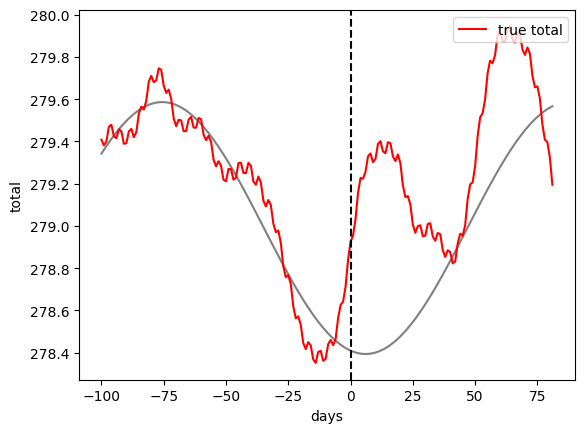

In [26]:
# COMPUTE METRIC OF PREDICTION
Integral_eval = np.trapz(np.trapz(X_eval, x, axis = 2), y, axis = 1)
Integral_true = np.trapz(np.trapz(X_true, x, axis = 2), y, axis = 1)

plt.plot(t, Integral_eval.T, color = 'grey')
plt.plot(t, Integral_true, label = 'true total', color = 'r')
plt.axvline(0, linestyle = '--', color = 'k')

plt.ylabel('total')
plt.xlabel('days')

plt.legend(loc = 'upper right')

In [27]:
contour_compare(X_true, X_eval)

interactive(children=(IntSlider(value=0, description='f_i(x,y)', max=181), IntSlider(value=90, description='f_…

In [28]:
rmse = np.linalg.norm(X_true - X_eval, axis = (1, 2)) / (X_true.shape[1] * X_true.shape[2])

In [29]:
rmse.shape

(182,)

Text(0, 0.5, 'RMSE (%)')

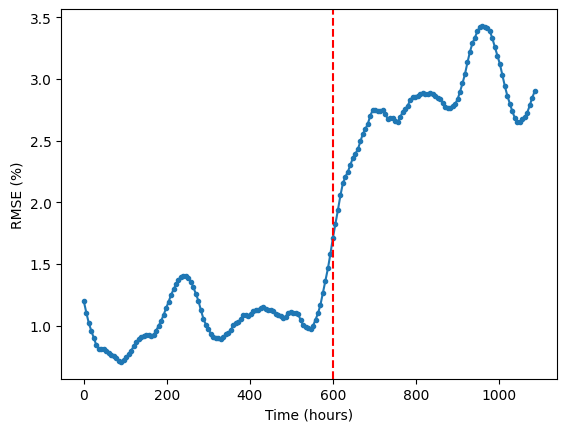

In [30]:
time_vector = np.arange(0, len(rmse))*delta_time_hrs
plt.plot(time_vector, rmse*100, '.-')
# add a vertical line at the time when the prediction starts
plt.axvline(T_train*delta_time_hrs, linestyle = '--', color = 'r')
plt.xlabel('Time (hours)')
plt.ylabel('RMSE (%)')

In [31]:
X_fitted = X_eval[:T_train, :, :]
timestamps_fitted = timestamps_windowed[:T_train]
X_pred = X_eval[T_train:, :, :]
timestamps_pred = timestamps_windowed[T_train:]

In [32]:
coords_pred = coords.copy()
coords_pred["time"] = timestamps_pred

In [33]:
X_pred = data_pipeline.array_to_dataarray(X_pred, attrs, coords_pred, dims)

In [34]:
X_pred

<xarray.DataArray (time: 82, latitude: 180, longitude: 180)> Size: 21MB
array([[[244.69014187, 244.69122508, 244.69222872, ..., 243.83004638,
         243.82799849, 243.82612153],
        [246.25563209, 246.26047466, 246.26461162, ..., 242.42084155,
         242.414001  , 242.40691953],
        [248.21226119, 248.2057662 , 248.19772612, ..., 242.57191363,
         242.55930497, 242.54854231],
        ...,
        [260.25450139, 260.25927067, 260.26759331, ..., 262.30687648,
         262.37062517, 262.43509253],
        [261.45494365, 261.44028103, 261.42468733, ..., 261.26247592,
         261.25451235, 261.24522953],
        [261.35522084, 261.31725829, 261.27956811, ..., 259.9229866 ,
         259.90780785, 259.89277245]],

       [[244.72272198, 244.72382828, 244.72485631, ..., 243.86142223,
         243.85930156, 243.85734749],
        [246.29047901, 246.29529768, 246.29940785, ..., 242.45274287,
         242.44560311, 242.43820899],
        [248.2479825 , 248.24165076, 248.23374817, ..., 242.61171924,
         242.5980969 , 242.58631693],
...
        [265.14465212, 265.13644254, 265.13067236, ..., 266.36445037,
         266.41034142, 266.45537683],
        [265.62797042, 265.61925004, 265.61060805, ..., 265.17631062,
         265.17272745, 265.16798682],
        [265.49414196, 265.47423425, 265.45424724, ..., 264.23879955,
         264.23369013, 264.22877625]],

       [[248.28890274, 248.28929232, 248.28968675, ..., 248.05335732,
         248.05277642, 248.05229933],
        [248.77831959, 248.7783573 , 248.77835971, ..., 247.62797894,
         247.63075476, 247.63389109],
        [249.56092096, 249.55881117, 249.55597982, ..., 247.5319011 ,
         247.5440644 , 247.55826374],
        ...,
        [265.07490795, 265.06695222, 265.06137186, ..., 266.27947907,
         266.3238819 , 266.36785193],
        [265.53545667, 265.5271772 , 265.51899398, ..., 265.10196978,
         265.09759155, 265.09211161],
        [265.39750019, 265.37786789, 265.35818157, ..., 264.16806628,
         264.16275949, 264.15763953]]])
Coordinates:
  * latitude   (latitude) float32 720B 89.75 88.75 87.75 ... -88.25 -89.25
    level      int64 8B 1000
  * longitude  (longitude) float32 720B 90.25 91.25 92.25 ... 267.2 268.2 269.2
  * time       (time) datetime64[ns] 656B 2020-02-07T12:00:00 ... 2020-02-27T...
Attributes:
    long_name:      Temperature
    short_name:     t
    standard_name:  air_temperature
    units:          K